In [5]:
def env_creator(env_config={}):
    import gymnasium as gym
    env = gym.make('FetchReach-v2', render_mode='rgb_array', reward_type='sparse', max_episode_steps=50)
    #env = SeededFetchReachEnv(env, 960)
    env.reset()
    return env

In [7]:
from stable_baselines3 import HerReplayBuffer, DDPG, DQN, SAC, TD3
from stable_baselines3.her.goal_selection_strategy import GoalSelectionStrategy
from stable_baselines3.common.envs import BitFlippingEnv

model_class = SAC  # works also with SAC, DDPG and TD3
N_BITS = 15

env = env_creator({})#BitFlippingEnv(n_bits=N_BITS, continuous=model_class in [DDPG, SAC, TD3], max_steps=N_BITS)

# Available strategies (cf paper): future, final, episode
goal_selection_strategy = "future" # equivalent to GoalSelectionStrategy.FUTURE

# Initialize the model
model = model_class(
    "MultiInputPolicy",
    env,
    replay_buffer_class=HerReplayBuffer,
    # Parameters for HER
    replay_buffer_kwargs=dict(
        n_sampled_goal=4,
        goal_selection_strategy=goal_selection_strategy,
    ),
    verbose=1,
)

# Train the model
model.learn(200000)

model.save("./her_Fetch-Reach_env")
# Because it needs access to `env.compute_reward()`
# HER must be loaded with the env
model = model_class.load("./her_Fetch-Reach_env", env=env)

obs, info = env.reset()
for _ in range(100):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = env.step(action)
    if terminated or truncated:
        obs, info = env.reset()

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate    | 0.0      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 127      |
|    time_elapsed    | 1        |
|    total_timesteps | 200      |
| train/             |          |
|    actor_loss      | -5.14    |
|    critic_loss     | 0.24     |
|    ent_coef        | 0.971    |
|    ent_coef_loss   | -0.197   |
|    learning_rate   | 0.0003   |
|    n_updates       | 99       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -48.9    |
|    success_rate    | 0.125    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 95       |
|    time_elapsed    

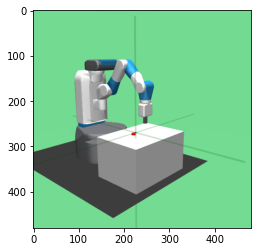

In [11]:
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
img = plt.imshow(env.render())

obs, info = env.reset()
for _ in range(200):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = env.step(action)
    if terminated or truncated:
        obs, info = env.reset()
    img.set_data(env.render()) # Just update the data
    ipythondisplay.display(plt.gcf())
    ipythondisplay.clear_output(wait=True)